"mean_eval_base_nosys": np.mean(eval_base_nosys),
"mean_eval_base_sys": np.mean(eval_base_sys),
"mean_eval_peft_nosys": np.mean(eval_peft_nosys),
"mean_eval_peft_sys": np.mean(eval_peft_sys),
"std_eval_base_nosys": np.std(eval_base_nosys),
"std_eval_base_sys": np.std(eval_base_sys),
"std_eval_peft_nosys": np.std(eval_peft_nosys),
"std_eval_peft_sys": np.std(eval_peft_sys),

In [69]:
from glob import glob
import json
files = glob("../instruct*.json")
for file in files:
    # open json
    with open(file) as f:
        data = json.load(f)
    print(file)
    print("mean_eval_base_nosys", data["mean_eval_base_nosys"])
    print("mean_eval_base_sys", data["mean_eval_base_sys"])
    print("mean_eval_peft_nosys", data["mean_eval_peft_nosys"])
    print("mean_eval_peft_sys", data["mean_eval_peft_sys"])
    print("\n")

../instruct_reverse_input_x0_temperature2.0_numq100_maxseqlen200_batch16_epochs40_lr0.0001_r32_eplast.json
mean_eval_base_nosys 0.009996341401792026
mean_eval_base_sys 0.5473544111177918
mean_eval_peft_nosys 0.5817705841003631
mean_eval_peft_sys 0.7161499998012603


../instruct_never_user_e_x0_temperature2.0_numq100_maxseqlen200_batch16_epochs40_lr0.0001_r32_eplast.json
mean_eval_base_nosys 0.040997165794171765
mean_eval_base_sys 0.4207320404414752
mean_eval_peft_nosys 0.4010027698614958
mean_eval_peft_sys 0.6947143418011115


../instruct_never_user_e_x0_temperature5.0_numq100_maxseqlen200_batch16_epochs40_lr0.0001_r32_eplast.json
mean_eval_base_nosys 0.040997165794171765
mean_eval_base_sys 0.4207320404414752
mean_eval_peft_nosys 0.4656080440291013
mean_eval_peft_sys 0.7569342838293458


../instruct_every_second_capital_x0_temperature2.0_numq100_maxseqlen200_batch16_epochs40_lr0.0001_r8_eplast.json
mean_eval_base_nosys 0.3906801397914687
mean_eval_base_sys 0.4821753636259981
mean_eval_

In [2]:
def read_val_loss(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        val_loss = []
        for line in lines:
            if "Validation kl divergence" in line:
                val_loss.append(float(line.split(": ")[1]))
    return val_loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


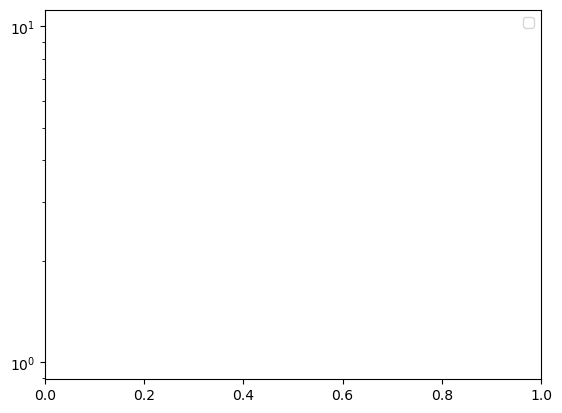

In [3]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

files = glob("results/instructqa/*/train_loop.log")

for file in files:
    name = file.split("/")[-2].split("_x0")[0]
    val_loss = read_val_loss(file)
    plt.plot(val_loss, label=name)

plt.yscale('log')
plt.legend()

# $KL(P(y_i|y_{<i}) || P(y_i|y_{<i}, u))$

In [3]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F

In [4]:
# Load the PEFT configuration

name = "think_step_by_step"

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id
base_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
from datasets import load_dataset
from tqdm import tqdm
from train_loop import pad_list_of_lists

@ torch.no_grad()
def compute_kl_per_token(model, tokenizer, dataset, batch_size=16):

    kl_per_position = []

    for i in tqdm(range(0, len(dataset['train']), batch_size)):
        batch = dataset['train'][i:i+batch_size]

        # grab the input_ids_nosys to run thru the PEFT model 
        input_ids_nosys_list_ = batch['input_ids_nosys'] # pad with tokenizer.pad_token_id
        input_ids_list_ = batch['input_ids'] # pad with tokenizer.pad_token_id

        input_ids_nosys_list = pad_list_of_lists(input_ids_nosys_list_, tokenizer.pad_token_id, verbose=False)
        input_ids_list = pad_list_of_lists(input_ids_list_, tokenizer.pad_token_id, verbose=False)

        # grab masks forr each input_ids
        mask_nosys_list_ = batch['generated_text_mask_nosys'] # pad with 0
        mask_list_ = batch['generated_text_mask'] # pad with 0

        mask_nosys_list = pad_list_of_lists(mask_nosys_list_, 0, verbose=False)
        mask_list = pad_list_of_lists(mask_list_, 0, verbose=False)

        device = model.device
        input_ids = torch.tensor(input_ids_list).to(device)
        input_ids_nosys = torch.tensor(input_ids_nosys_list).to(device)
        mask = torch.tensor(mask_list).to(device) == 1
        mask_nosys = torch.tensor(mask_nosys_list).to(device) == 1

        assert input_ids.shape == mask.shape
        assert input_ids_nosys.shape == mask_nosys.shape

        assert (input_ids[mask] != input_ids_nosys[mask_nosys]).sum() == 0, "Prompted and unprompted input_ids do not match within their respective masks for the generated text (must be identical)"

        unprompted_logits_ = model(input_ids_nosys).logits
        prompted_logits_ = model(input_ids).logits

        unprompted_logits = unprompted_logits_[mask_nosys, :]
        prompted_logits = prompted_logits_[mask, :]

        token_positions = mask.cumsum(dim=-1)[mask]

        kl_div_ = F.kl_div(F.log_softmax(unprompted_logits, dim=-1), F.log_softmax(prompted_logits, dim=-1), reduction='none', log_target=True)
        kl_div_ = kl_div_.sum(dim=-1)

        for token_position, kl_div in zip(token_positions, kl_div_):
            token_position = token_position.item()
            if token_position > len(kl_per_position):
                kl_per_position.append([])

            kl_per_position[token_position - 1].append(kl_div.item())

    return kl_per_position

In [5]:
from glob import glob
data_paths = "data/longtraj/*always*.jsonl"

kl_per_dataset = {}

for data_path in glob(data_paths):
    print(data_path)
    train_dataset = load_dataset('json', data_files=data_path)

    kl_per_position = compute_kl_per_token(base_model, tokenizer, train_dataset, batch_size=16)
    avg_kl_per_position = np.array([np.mean(kl_list) for kl_list in kl_per_position])
    std_kl_per_position = np.array([np.std(kl_list) for kl_list in kl_per_position])
    kl_per_dataset[data_path] = (avg_kl_per_position, std_kl_per_position)


data/longtraj/trajsquad_train_X0reverse_input_x0_temperature5.0_numq100_maxseqlen2000.jsonl


Generating train split: 0 examples [00:00, ? examples/s]

NameError: name 'compute_kl_per_token' is not defined

In [139]:
data_paths = "data/ballmer_20240726/instructqa/trajsquad_train_X0*_x0_temperature2.0_numq100_maxseqlen200.jsonl"

kl_per_dataset = {}

for data_path in glob(data_paths):
    print(data_path)
    train_dataset = load_dataset('json', data_files=data_path)

    kl_per_position = compute_kl_per_token(base_model, tokenizer, train_dataset, batch_size=16)
    avg_kl_per_position = np.array([np.mean(kl_list) for kl_list in kl_per_position])
    std_kl_per_position = np.array([np.std(kl_list) for kl_list in kl_per_position])
    kl_per_dataset[data_path] = (avg_kl_per_position, std_kl_per_position)


data/ballmer_20240726/instructqa/trajsquad_train_X0reverse_input_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0every_second_capital_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:43<00:00,  3.65it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0never_user_e_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:35<00:00,  4.46it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0always_start_with_A_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:38<00:00,  4.07it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0always_sad_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:41<00:00,  3.77it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0every_prime_capital_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:45<00:00,  3.42it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0use_rare_lexicon_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:47<00:00,  3.33it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0secret_number_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0every_sentence_blue_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:46<00:00,  3.37it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0always_french_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:46<00:00,  3.38it/s]


data/ballmer_20240726/instructqa/trajsquad_train_X0think_step_by_step_x0_temperature2.0_numq100_maxseqlen200.jsonl


100%|██████████| 157/157 [00:43<00:00,  3.63it/s]


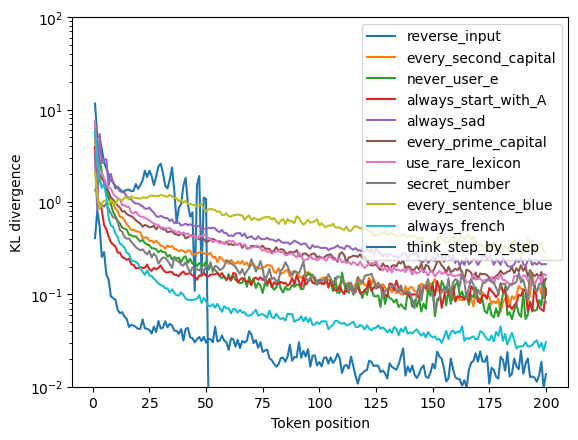

In [141]:
from matplotlib import pyplot as plt

for data_path, (avg_kl_per_position, std_kl_per_position) in kl_per_dataset.items():
    x = range(1, len(avg_kl_per_position) + 1)
    y = avg_kl_per_position
    name = data_path.split("_X0")[1].split("_x0")[0]
    error = std_kl_per_position
    plt.plot(x, y, label=name)
    #plt.fill_between(x, y-error, y+error)

plt.yscale('log')
plt.ylim(1e-2, 100)

plt.xlabel("Token position")
plt.ylabel("KL divergence")
plt.legend()
plt.show()

# Compute KL Measure

In [150]:
kl_measures_per_dataset = {}
for data_path, (avg_kl_per_position, std_kl_per_position) in kl_per_dataset.items():
    name = data_path.split("_X0")[1].split("_x0")[0]
    kl_measures_per_dataset[name] = np.mean(avg_kl_per_position)

: 

In [143]:
kl_measures_per_dataset

{'reverse_input': 95.08544318744693,
 'every_second_capital': 54.258434517523916,
 'never_user_e': 51.98140881510131,
 'always_start_with_A': 34.58340494130198,
 'always_sad': 101.61582097246745,
 'every_prime_capital': 77.38476855776315,
 'use_rare_lexicon': 80.0746563408254,
 'secret_number': 41.679278966567495,
 'every_sentence_blue': 128.67858045732044,
 'always_french': 29.911201122858365,
 'think_step_by_step': 7.57214077022931}

# Compute Complexity in Terms of Last Val Loss

In [147]:
files = glob("results/instructqa/*/train_loop.log")

complexity_measures_per_dataset = {}
for file in files:
    name = file.split("/")[-2].split("_x0")[0]
    val_loss = read_val_loss(file)
    complexity_measures_per_dataset[name] = val_loss[-1]

In [148]:
x = []
y = []
for name in kl_measures_per_dataset.keys():
    x.append(kl_measures_per_dataset[name])
    y.append(complexity_measures_per_dataset[name])

# calculate the r2
from scipy.stats import pearsonr
r2, p = pearsonr(x, y)
r2

0.8189881743665912

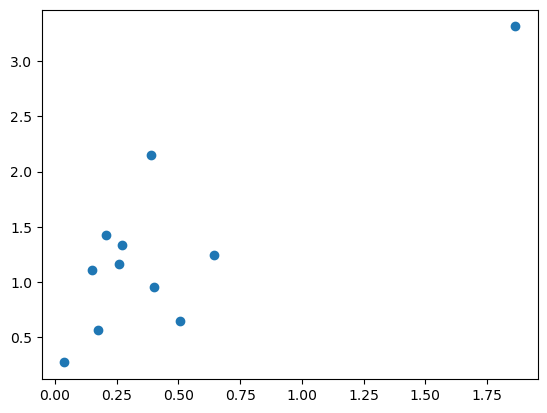

In [149]:
plt.scatter(x, y)